In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt  


## This is a demo file for pyCCUS test drive, designed for JD

#### Step 1: have your CMG model ready as the input to pyCCUS
#### Step 2: get your parameter space ready
- This example demo alters the values of permeability, porosity, and injection rate

In [2]:
##### User input #####
# folder_path = '../data/omv/CCS/testdrive1'
folder_path = '..\\data\\omv\\CCS\\testdrive1'

params = ['phi',
          'perm_mult, md',
          'inj_rate, m3/d']

l_bounds = [0.15, 8000, 1e6]
u_bounds = [0.25, 11000, 9e6]

num_of_exp = 3
##### User input #####

In [ ]:
##### Latin Hyper Cube sampling to create the params space #####
from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=len(params))
sample = sampler.random(n=num_of_exp)

sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

df = pd.DataFrame(data=np.round(sample_scaled,2), columns=params)

df['perm, md'] = df['phi'] * df['perm_mult, md']

##### Save your exp design if needed #####
if not os.path.isdir(folder_path):
    os.makedirs(folder_path)
df.to_csv(os.path.join(folder_path, 'exp_design.csv'), index=False)

- Write CMG models (dat files) based on the DoE

In [3]:
df = pd.read_csv(os.path.join(folder_path, 'exp_design.csv'))
df_input = df.iloc[:,[0,2,3]]
df_input = df_input.rename(columns={'phi': 'phi', 
                                    'inj_rate, m3/d': 'inj_rate',
                                    'perm, md': 'perm'})

In [4]:
import sys
# append the path of the parent directory
sys.path.append("..")
# import method from sibling module
from utils.pyCMG_Model import omv_CCS
from utils.pySherlock import pysherlock

In [5]:
omvccs = omv_CCS()
omvccs.folder_path = folder_path
omvccs.title1 = 'pyCCUS testdrive'
omvccs.title2 = 'CCS omv'
omvccs.title3 = 'JD+YL'

In [6]:
omvccs.write_simfiles(df_input=df_input, verbose=True)

Job done -- write 3 CMG dat files based on exp design csv .....


## Run CMG files
- Option 1: local win machine
- Option 2: Stanford sherlock HPC

In [7]:
from utils.pyCMG_Control import pycmgcontrol

for nn in range(df_input.shape[0]):
    pycmg_ctrl = pycmgcontrol(exp_name=f'case{nn+1}.dat', simfolder=os.path.join(folder_path, 'datfiles'))
    # Available optoins: 'ese-win32-v2022.30', 'ese-ts1win-v2023.20', 'stf-sherlock-v2020.10', 'ese-ts2win-v2024.20'
    pycmg_ctrl.cmg_version = 'ese-ts2win-v2024.20'

    pycmg_ctrl.run_gem_simulation(case_name_suffix=f'case{nn+1}.dat')

### Option 2: run CMG on Sherlock
- You will also need submit.sh file

In [ ]:
# sherlock = pysherlock()
# pyCTRL_folder_path = os.path.join(folder_path, 'pyCTRLfiles')

# for idx in range(df_input.shape[0]):
#     sherlock.write_pyCTRLfile(folder_path=pyCTRL_folder_path, caseid=idx+1)

### Extract the result in npy format

In [7]:
from utils.pyCMG_Control import pycmgcontrol

In [8]:
for nn in range(df_input.shape[0]):
    pycmg_ctrl = pycmgcontrol(exp_name=f'case{nn+1}.dat', simfolder=os.path.join(folder_path, 'datfiles'))
    # Available optoins: 'ese-win32-v2022.30', 'ese-ts1win-v2023.20', 'stf-sherlock-v2020.10'
    pycmg_ctrl.cmg_version = 'ese-ts2win-v2024.20'
    pycmg_ctrl.rwd_precis = 4
    pycmg_ctrl.proplist = ['SG','PRES']
    pycmg_ctrl.layer_nums = [1,2,3]
    pycmg_ctrl.time_query = [2024, 2026, 2028, 2030, 2032, 2034]
    ##### Params to control rwo2npy steps ######
    pycmg_ctrl.XY2arr_interp_method = "cubic"  # options = {‘linear’, ‘nearest’, ‘cubic’}
    pycmg_ctrl.XY2arr_interp_num_x = 100
    pycmg_ctrl.XY2arr_interp_num_y = 100
    pycmg_ctrl.x_dir_key = 'X'
    pycmg_ctrl.y_dir_key = 'Y'

    pycmg_ctrl.cmgrst2npy(caseid=f"{nn+1}",
                              verbose=False, 
                              rwodelete=False)
    npy_data = pycmg_ctrl.cmg2npy

#     # try datfiles or simfiles depending on different computing env
#     if not os.path.isdir(os.path.join(folder_path, 'datfiles', 'rst_npy')):
#         os.makedirs(os.path.join(folder_path, 'datfiles', 'rst_npy'))
#     np.save(os.path.join(folder_path, 'datfiles', 'rst_npy', f'case{nn+1}.npy'), arr = npy_data)

## debug code

### test function read_rwo2csv

In [11]:
    def read_rwo2csv(path2file, 
                     save2csv=None):
        """
        Goal: reads rwo files to csv format. The rwo file is prop values at X, Y location.

        Input:  path2file directions the function to the rwo file.
                save2csv: path+name of the csv file to be saved, if not None.
        Output: csv file includes colums: X, Y, prop @ time steps output in rwo files. 
                (Num of rows should be the number of grids in a layer of the model)
                example format of a column: "Gas Saturation_2023-Jan-01"
        """
        # read data from file
        with open(path2file) as file:
            lines = file.readlines()
        # organize data in dict format    
        cache = {}
        count = 0
        
        for i in range(len(lines)):
            try:
                # This means a new time step
                if lines[i].split()[1] == 'TIME:':
                    if count > 0:
                        cache[key] = pressure
                    count += 1
                    pressure = []
    #                 key = lines[i+1].split(':')[-1]+'_'+str(count)
    #                 key = lines[i+1].split(':')[-1]+'_'+lines[i].split()[-1]
                    prop_name = ' '.join(lines[i+1].split(':')[-1].split())
                    key = prop_name+'_'+lines[i].split()[-1]

                if lines[i].split()[0] == '**' or lines[i].split()[0] == '<' or not lines[i].split():
                    pass
                else:
                    x = float(lines[i].split()[0])
                    y = float(lines[i].split()[1])
                    prop = float(lines[i].split()[2])
                    pressure.append((x,y,prop))
            except:
                pass
        # Record the last item
        cache[key] = pressure
            
        # convert cache in dict to a pd dataframe
        df = pd.DataFrame({})
        df['X'] = np.array(cache[list(cache.keys())[0]])[:,0]
        df['Y'] = np.array(cache[list(cache.keys())[0]])[:,1]
        for item in cache.keys():
            df[item] = np.array(cache[item])[:,2]
        
        # If need to save the data in CSV format
        if save2csv is not None:
            df.to_csv(save2csv, index=False)
        return df

In [12]:
df = read_rwo2csv(path2file=os.path.join(folder_path, 'datfiles', 'rwo_case2', 'case2_PRES_layer1.rwo'))
df

,X,Y,Pressure_2024-Jan-01,Pressure_2026-Jan-01,Pressure_2028-Jan-01,Pressure_2030-Jan-01,Pressure_2032-Jan-01,Pressure_2034-Jan-01
0,555529.31,6714351.88,19091.6,19171.9,19314.7,19458.5,19610.2,19765.7
1,555078.70,6714390.50,19270.7,19351.0,19493.9,19637.6,19789.4,19944.9
2,554620.59,6714430.75,19466.7,19547.0,19689.9,19833.6,19985.4,20140.9
3,554158.45,6714472.00,19695.9,19776.3,19919.2,20063.0,20214.8,20370.3
4,553694.11,6714513.75,19881.1,19961.7,20104.6,20248.4,20400.2,20555.7
...,...,...,...,...,...,...,...,...
8067,536893.36,6665637.50,28274.6,28362.7,28509.9,28655.6,28809.4,28962.5
8068,536343.33,6665664.00,28417.6,28506.6,28653.9,28799.6,28953.5,29106.7
8069,535794.03,6665690.75,28554.4,28644.2,28791.8,28937.5,29091.4,29244.6
8070,535246.01,6665717.75,28684.9,28775.5,28923.2,29068.9,29222.8,29376.0


### test function xy_interp_to_arr

In [13]:
    def xy_interp_to_arr(df, num_x, num_y, interp_method, query, x_dir_key='X', y_dir_key='Y'):
        """
        interp_method = {‘linear’, ‘nearest’, ‘cubic’}
        num_x, num_y = int. Number of query pts along x or y axis.
        x, y, values = df columns
        """

        x = df[x_dir_key].values
        y = df[y_dir_key].values
        val = df[query].values

        # Define grid
        xi = np.linspace(np.min(x), np.max(x), num_x)
        yi = np.linspace(np.min(y), np.max(y), num_y)
        x_new, y_new = np.meshgrid(xi, yi)

        val_new = griddata((x, y), val, (x_new, y_new), method=interp_method)

        return x_new, y_new, val_new

In [33]:
from scipy.interpolate import griddata
x_new, y_new, val_new = xy_interp_to_arr(df, 100, 100, 'linear', 'Pressure_2026-Jan-01', x_dir_key='X', y_dir_key='Y')
val_new

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [36]:
x_new.shape, y_new.shape, val_new.shape

((100, 100), (100, 100), (100, 100))

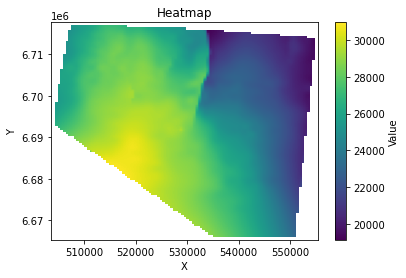

In [37]:
plt.imshow(val_new, extent=[x_new.min(), x_new.max(), y_new.min(), y_new.max()], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap')
plt.show()

### test function rwo_reader2arr

In [50]:
    def rwo_reader2arr(folder, sim, prop, layer_nums, time_query, x_dir_key, y_dir_key):
        """
        Goal: combine rwo_reader2df and rwodf2arr in a 4d (n,m,z,t) array for output.

        Inputs: 1. folder: path to the sim run folder, example="../data/EPA_baseline/"
                2. sim: simulation run name, example="EPA_baseline_dev2East_debug"
                3. prop: CMG keyword for property 'SG', 'PRES', 'VERDSPLGEO', etc.
                4. layer_nums: list or array in 1d
                5. query: in format of [list] or arr for years. example=['Gas Saturation_2027-Jan-01', ..., 'Gas Saturation_2100-Jan-01']
        """
        df0 = read_rwo2csv(os.path.join(folder, f'{sim}_{prop}_layer{layer_nums[0]}.rwo'))

        
        #JD
        XY2arr_interp_num_x = 100
        XY2arr_interp_num_y = 100
        XY2arr_interp_method = "cubic"  # options = {‘linear’, ‘nearest’, ‘cubic’}

        x_new, y_new, arr0 = xy_interp_to_arr(df=df0, 
                                                   num_x=XY2arr_interp_num_x, num_y=XY2arr_interp_num_y, interp_method=XY2arr_interp_method, 
                                                   query=time_query[0], x_dir_key=x_dir_key, y_dir_key=y_dir_key)

        # Retire the old version, b/c it does not handle the case that X and Y do not align
        # arr0 = self.rwodf2arr(df=df0, query=time_query[0], x_dir_key='X', y_dir_key='Y')

        n,m = arr0.shape
        z = len(layer_nums)
        t = len(time_query)

        rst_arr = np.zeros((n,m,z,t))
        for il,ll in enumerate(layer_nums):
            globals()[f'df{prop}_lyr{ll}'] = read_rwo2csv(os.path.join(folder, f'{sim}_{prop}_layer{ll}.rwo'))
            for it, tt in enumerate(time_query):
                _, _, globals()[f'arr{prop}_lyr{ll}_{tt}'] = xy_interp_to_arr(df=globals()[f'df{prop}_lyr{ll}'], 
                                                                                   num_x=XY2arr_interp_num_x, 
                                                                                   num_y=XY2arr_interp_num_y, 
                                                                                   interp_method=XY2arr_interp_method, 
                                                                                   query=tt, x_dir_key=x_dir_key, y_dir_key=y_dir_key)
                # Retire the old version, b/c it does not handle the case that X and Y do not align
                # globals()[f'arr{prop}_lyr{ll}_{tt}'] = self.rwodf2arr(df=globals()[f'df{prop}_lyr{ll}'], query=tt, x_dir_key=x_dir_key, y_dir_key=y_dir_key)
                rst_arr[:,:,il,it] = globals()[f'arr{prop}_lyr{ll}_{tt}']
        return x_new, y_new, rst_arr

In [53]:
folder=os.path.join(folder_path, 'datfiles','rwo_case2')
sim='case2'
prop='PRES'
layer_nums=[1,2,3]
time_query=['Pressure_2026-Jan-01']
x_dir_key='X'
y_dir_key='Y'

x_new2, y_new2, rst_arr2=rwo_reader2arr(folder, sim, prop, layer_nums, time_query, x_dir_key, y_dir_key)
# df0 = read_rwo2csv(os.path.join(folder, f'{sim}_{prop}_layer{layer_nums[0]}.rwo'))
# XY2arr_interp_num_x = 100
# XY2arr_interp_num_y = 100
# XY2arr_interp_method = "cubic"  # options = {‘linear’, ‘nearest’, ‘cubic’}
# x_new, y_new, arr0 = xy_interp_to_arr(df=df0, num_x=XY2arr_interp_num_x, num_y=XY2arr_interp_num_y, 
#                                       interp_method=XY2arr_interp_method, 
#                                       query=time_query[0], x_dir_key=x_dir_key, y_dir_key=y_dir_key)
# # x_new, y_new, arr0 = xy_interp_to_arr(df0, 100, 100, 'cubic', 'Pressure_2026-Jan-01', 'X', 'Y')                              
# arr0
y_new2
rst_arr2

array([[[[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]],

        ...,

        [[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]]],


       [[[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]],

        ...,

        [[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]]],


       [[[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]],

        ...,

        [[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan]]],


       ...,


       [[[nan],
         [nan],
      

### JD: found issue "y_dir_key=x_dir_key"

x_new, y_new, arr0 = xy_interp_to_arr(df=df0, 
                                    num_x=XY2arr_interp_num_x, num_y=XY2arr_interp_num_y, interp_method=XY2arr_interp_method, 
                                    query=time_query[0], x_dir_key=x_dir_key, y_dir_key=x_dir_key)